# Create group snapshots

## About snapshots

Functions in `patientflow` help you convert patient-level predictions into a predicted bed count distributions for groups of patients at a point in time. As a reminder, the package is organised around the following concepts:

- Prediction time: A moment in the day at which predictions are to be made, for example 09:30.
- Patient snapshot: A summary of data from the EHR capturing is known about a single patient at the prediction time. Each patient snapshot has a date and a prediction time associated with it.
- Group snaphot: A set of patients snapshots. Each group snapshot has a date and a prediction time associated with it.
- Prediction window: A period of hours that begins at the prediction time.

In this notebook, I show how to prepare a group snapshot, using fake data that resembles visits to the Emergency Department (ED). In this example, a group snapshot comprises all patients who were in the ED at a point in time.  

I then demonstrate the use of a simple model that predicts admission for each patient, and show how those predictions can be aggregated into a prediction for the number of beds needed for the patients comprising the group snapshot.

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

## Set up prediction times

The first step is to specify the times of day at which we want to create predictions. 

In [2]:
prediction_times = [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)] # each time is expressed as a tuple of (hour, minute)

## Create patient snapshots 

We'll create some patient shapshots, using some fake data, generated within this notebook, on patients in an Emergency Department (ED). See the [2a_Create_patient_snapshots](2a_Create_patient_snapshots.ipynb) notebook for more information about to convert finished hospital visits into snapshots. 

In [3]:
from patientflow.generate import create_fake_snapshots
prediction_times = [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)] 
snapshots_df=create_fake_snapshots(prediction_times=prediction_times, 
                                   start_date='2023-01-01', 
                                   end_date='2023-04-01',
                                   mean_patients_per_day=100)
snapshots_df.head()


,snapshot_date,prediction_time,patient_id,visit_number,is_admitted,age,latest_triage_score,num_cbc_orders,num_troponin_orders,num_urinalysis_orders,num_bmp_orders,num_d-dimer_orders
snapshot_id,,,,,,,,,,,,
0,2023-01-01,"(6, 0)",270,1,0,47,5.0,1,0,0,0,0
1,2023-01-01,"(6, 0)",3678,12,1,44,2.0,0,1,1,0,0
2,2023-01-01,"(9, 30)",6514,86,0,43,4.0,1,1,0,1,0
3,2023-01-01,"(9, 30)",4956,26,0,53,5.0,1,0,1,0,0
4,2023-01-01,"(9, 30)",3741,9,1,66,4.0,1,0,0,0,0


Note that each record in the snapshots dataframe is indexed by a unique snapshot_id. 

## Create group snapshots

For each combination of snapshot_date and prediction_time, we can identify the group of patients in the ED at that moment. These patients comprise the group snapshot. `patientflow` includes a `prepare_group_snapshot_dict()` function. As input, it requires a pandas dataframe with a `snapshot_date` column. If a start date and end date are provided, the function will check for any intervening snapshot dates that are missing, and create an empty group snapshot for this date

The keys of the dictionary are the snapshot_date. The values are a list of patients in the ED at that time, identified by their unique `snapshot_id`.

Here I create a group snapshot dictionary for patients in the ED at 09.30


In [4]:
from patientflow.prepare import prepare_group_snapshot_dict

# select the snapshots to include in the probability distribution, 
group_snapshots_dict = prepare_group_snapshot_dict(
    snapshots_df[snapshots_df.prediction_time == (9,30)]
    )

print("First 10 keys in the snapshots dictionary")
print(list(group_snapshots_dict.keys())[0:10])


First 10 keys in the snapshots dictionary
[datetime.date(2023, 1, 1), datetime.date(2023, 1, 2), datetime.date(2023, 1, 3), datetime.date(2023, 1, 4), datetime.date(2023, 1, 5), datetime.date(2023, 1, 6), datetime.date(2023, 1, 7), datetime.date(2023, 1, 8), datetime.date(2023, 1, 9), datetime.date(2023, 1, 10)]


From the first key in the dictionary, we can see the patients belonging to this first snapshot. 

In [5]:
first_group_snapshot_key = list(group_snapshots_dict.keys())[0]
first_group_snapshot_values = group_snapshots_dict[first_group_snapshot_key]

print(f"\nThere are {len(first_group_snapshot_values)} patients in the first group snapshot")

print("\nUnique snapshot_ids in the first group snapshot:")
print(first_group_snapshot_values)

# print("\nPatient snapshots belonging to the first group snapshot:")
# snapshots_df.loc[first_group_snapshot_values]


There are 12 patients in the first group snapshot

Unique snapshot_ids in the first group snapshot:
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


 More useful is to return not just the indices, but also the data for each visit in the group snapshot. This can be done with the `get_snapshots_at_prediction_time`

In [6]:
from patientflow.prepare import prepare_patient_snapshots

first_snapshot_prepared_for_model, _ = prepare_patient_snapshots(
    df=snapshots_df.loc[first_group_snapshot_values], 
    prediction_time=(9,30),
    single_snapshot_per_visit=False
)
first_snapshot_prepared_for_model

,snapshot_date,prediction_time,patient_id,visit_number,age,latest_triage_score,num_cbc_orders,num_troponin_orders,num_urinalysis_orders,num_bmp_orders,num_d-dimer_orders
snapshot_id,,,,,,,,,,,
2,2023-01-01,"(9, 30)",6514,86,43,4.0,1,1,0,1,0
3,2023-01-01,"(9, 30)",4956,26,53,5.0,1,0,1,0,0
4,2023-01-01,"(9, 30)",3741,9,66,4.0,1,0,0,0,0
5,2023-01-01,"(9, 30)",5287,41,60,4.0,1,0,0,0,0
6,2023-01-01,"(9, 30)",872,16,59,3.0,1,0,0,0,0
7,2023-01-01,"(9, 30)",2108,20,68,3.0,0,0,0,1,0
8,2023-01-01,"(9, 30)",6748,67,43,2.0,0,0,1,0,0
9,2023-01-01,"(9, 30)",2282,28,73,1.0,0,1,1,0,1
10,2023-01-01,"(9, 30)",2502,50,63,3.0,0,0,0,0,0


## Prepare a model that can make predictions for each patient snapshot

In the cell below, I'm using `create_temporal_splits()` to create a training, validation and test set and `train_classifier()` `patientflow`to prepare a XGBoost classifier. This classifier will be used to make predictions. 

In [7]:
from datetime import date   
from patientflow.prepare import create_temporal_splits
from patientflow.train.classifiers import train_classifier

# set the temporal split
start_training_set = date(2023, 1, 1) 
start_validation_set = date(2023, 2, 15) # 6 week training set 
start_test_set = date(2023, 3, 1) # 2 week validation set 
end_test_set = date(2023, 4, 1) # 1 month test set

# create the temporal splits
train_visits, valid_visits, test_visits = create_temporal_splits(
    snapshots_df,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date", # states which column contains the date to use when making the splits 
    patient_id="patient_id", # states which column contains the patient id to use when making the splits 
    visit_col="visit_number", # states which column contains the visit number to use when making the splits 

)
# exclude columns that are not needed for training
exclude_from_training_data=['visit_number', 'snapshot_date', 'prediction_time']

# the function will only include one snapshot for each visit. visit_col specifies which column contains the visit number
visit_col='visit_number'

# train the patient-level model
model = train_classifier(
    train_visits,
    valid_visits,
    test_visits,
    grid={"n_estimators": [30]},
    prediction_time=(9, 30),
    exclude_from_training_data=exclude_from_training_data,
    ordinal_mappings={'latest_triage_score': [1, 2, 3, 4, 5]},
    visit_col=visit_col,
    use_balanced_training=True,
    calibrate_probabilities=True
)



Patient Set Overlaps (before random assignment):
Train-Valid: 0 of 4338
Valid-Test: 75 of 3019
Train-Test: 226 of 5084
All Sets: 0 of 6070 total patients
Split sizes: [3706, 1205, 2486]


## Using the trained model, get bed count probability for one snapshot

`prepare_patient_snapshots()` gets patients snapshots ready for model training. Although we've already done that above, that was for the whole data. Here we are doing it for each group snapshot at a time. 

In [17]:
from patientflow.prepare import prepare_patient_snapshots

first_snapshot_X_test, first_snapshot_y_test = prepare_patient_snapshots(
    df=snapshots_df.loc[first_group_snapshot_values], 
    prediction_time=(9,30), 
    single_snapshot_per_visit=False,
    exclude_columns=exclude_from_training_data, 
    visit_col=visit_col
)
first_snapshot_X_test


,patient_id,age,latest_triage_score,num_cbc_orders,num_troponin_orders,num_urinalysis_orders,num_bmp_orders,num_d-dimer_orders
snapshot_id,,,,,,,,
2,6514,43,4.0,1,1,0,1,0
3,4956,53,5.0,1,0,1,0,0
4,3741,66,4.0,1,0,0,0,0
5,5287,60,4.0,1,0,0,0,0
6,872,59,3.0,1,0,0,0,0
7,2108,68,3.0,0,0,0,1,0
8,6748,43,2.0,0,0,1,0,0
9,2282,73,1.0,0,1,1,0,1
10,2502,63,3.0,0,0,0,0,0


From the output below, we can see a probability distribution for the number of beds needed for the 12 patients in the ED at the snapshot date and prediction time

In [14]:
from patientflow.aggregate import get_prob_dist_for_prediction_moment

bed_count_prob_dist = get_prob_dist_for_prediction_moment(
    first_snapshot_X_test, model, weights=None, inference_time=True, y_test=None
)

bed_count_prob_dist['agg_predicted'].rename(columns={'agg_proba': 'prob_of_bed_count'})


,prob_of_bed_count
0,0.00533775830677513
1,0.0392825576874872
2,0.125403139142556
3,0.228041241357069
4,0.261206918322790
5,0.197207986851194
6,0.100089187290002
7,0.0342908683138889
8,0.00785486317002788
9,0.00117176078510014


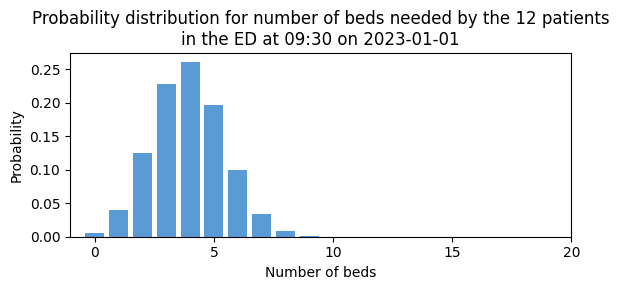

In [16]:
from patientflow.viz.prob_dist_plot import prob_dist_plot
from patientflow.viz.utils import format_prediction_time
title = (
    f'Probability distribution for number of beds needed by the '
    f'{len(first_snapshot_X_test)} patients\n'
    f'in the ED at {format_prediction_time((9,30))} '
    f'on {first_group_snapshot_key}'
)
prob_dist_plot(bed_count_prob_dist['agg_predicted'], title,  
    include_titles=True)


## Make predictions for group snapshots

Now we'll make predictions for the whole test set. 

In [20]:

X_test, y_test = prepare_patient_snapshots(
    df=snapshots_df.loc[first_group_snapshot_values], 
    prediction_time=(9,30), 
    single_snapshot_per_visit=False,
    exclude_columns=exclude_from_training_data, 
    visit_col=visit_col
)




In [89]:
X_test.head()

,age,latest_triage_score,num_d-dimer_orders,num_cbc_orders,num_troponin_orders,num_bmp_orders,num_urinalysis_orders
snapshot_id,,,,,,,
5082,41,2.0,0,1,0,1,1
5081,38,4.0,1,0,0,0,0
5084,13,5.0,0,0,0,0,0
5087,28,2.0,0,0,0,0,0
5076,61,4.0,1,0,0,0,0


In [90]:
from patientflow.aggregate import get_prob_dist

group_snapshots_dict = prepare_group_snapshot_dict(
    test_visits[test_visits.prediction_time == (9,30)]
    )
# get probability distribution for this time of day
prob_dists_for_group_snapshots = get_prob_dist(
        group_snapshots_dict, X_test, y_test, pipeline
    )

Calculating probability distributions for 31 snapshot dates
This may take a minute or more


ValueError: columns are missing: {'snapshot_datetime'}

In [71]:
type(prob_dists_for_group_snapshots)

dict

In [72]:
list(prob_dists_for_group_snapshots.keys())[0:5]

[datetime.date(2023, 3, 1),
 datetime.date(2023, 3, 2),
 datetime.date(2023, 3, 3),
 datetime.date(2023, 3, 4),
 datetime.date(2023, 3, 5)]